In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense ,Input
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
datasets_dir = os.path.join(os.getcwd(), 'datasets')
file_name = 'JPM_2006-01-01_to_2018-01-01.csv'
file_path = os.path.join(datasets_dir, file_name)
df = pd.read_csv(file_path)

In [4]:
diff_close_series = df['Close'].diff().dropna()

In [38]:
lag_df = pd.DataFrame({
    't-1': diff_close_series.shift(1),
    't': diff_close_series,
    't+1': diff_close_series.shift(-1)
}).dropna()

In [39]:
lag_df['diff t-1'] = lag_df['t'] - lag_df['t-1']
lag_df['diff t'] = lag_df['t+1'] - lag_df['t']

In [40]:
split_idx = len(lag_df) // 2
train_data = lag_df.iloc[:split_idx]
test_data = lag_df.iloc[split_idx:]

In [41]:
X_train = train_data[['diff t-1', 't']].values
y_train = train_data['t+1'].values

In [42]:
X_test = test_data[['diff t-1', 't']].values
y_test = test_data['t+1'].values

In [44]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

In [45]:
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))


In [46]:
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [47]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

In [62]:
input_layer = Input(shape=(1, 2)) 

In [63]:
model = Sequential([
    Input(shape=(1, 2)),  # Define input shape separately
    LSTM(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

In [64]:
model.fit(X_train_reshaped, y_train_scaled, epochs=500, batch_size=8, verbose=0)

In [65]:
X_input = X_test_scaled.copy()
y_pred_scaled = []

In [66]:
for i in range(len(X_test_scaled)):
    X_reshaped = X_input[i].reshape(1, 1, 2)  # Reshape for LSTM
    pred_scaled = model.predict(X_reshaped)[0, 0]  # Predict t+1
    y_pred_scaled.append(pred_scaled)

    # Update input for the next iteration
    if i < len(X_test_scaled) - 1:
        X_input[i + 1, 0] = X_input[i, 1]  # Move t → t-1
        X_input[i + 1, 1] = pred_scaled 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

In [67]:
y_pred = scaler_y.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1))

In [68]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"LSTM MSE: {mse:.6f}")
print(f"LSTM R²: {r2:.6f}")

LSTM MSE: 0.644868
LSTM R²: -0.000566


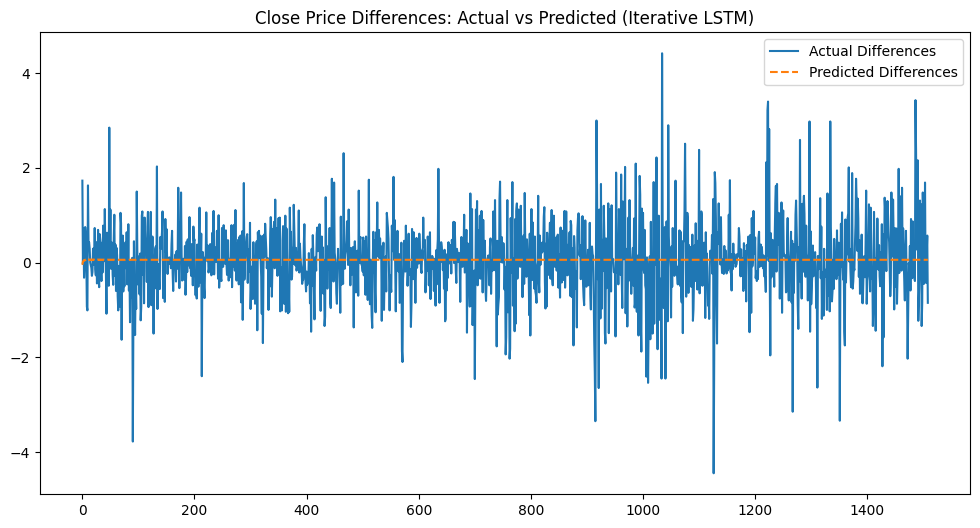

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Differences')
plt.plot(y_pred, label='Predicted Differences', linestyle='dashed')
plt.title("Close Price Differences: Actual vs Predicted (Iterative LSTM)")
plt.legend()
plt.show()

In [ ]:
# lagdata = pd.concat(
#     [diff_close_series.shift(i) for i in range(5, -1, -1)],
#     axis=1
# ).dropna()
# lagdata.columns = [f'lag_{i}' for i in range(5, -1, -1)]
# X = lagdata.iloc[:, 1:].values  
# y = lagdata.iloc[:, 0].values

In [6]:
#diffcloseseires = df['Close'].diff().dropna()

In [7]:
scalerx = StandardScaler()
xscaled = scalerx.fit_transform(X)

In [8]:
X_reshaped = xscaled.reshape((xscaled.shape[0], xscaled.shape[1], 1))

In [9]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_reshaped.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2025-02-22 09:36:05.745701: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/ryu/code/minorproject/VENV/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.fit(X_reshaped, y, epochs=200, batch_size=8, verbose=0)

In [11]:
ypredlist = []

In [12]:
for i in range(len(xscaled)):
    X_input = xscaled[i].reshape((1, X_reshaped.shape[1], 1))
    
    y_pred_raw = model.predict(X_input, verbose=0)
    ypredlist.append(y_pred_raw[0][0]) 

In [13]:
y_pred = np.array(ypredlist)

scaler_y = StandardScaler()
y_scaled_actual = scaler_y.fit_transform(y.reshape(-1, 1))
y_scaled_pred = scaler_y.transform(y_pred.reshape(-1, 1))

In [14]:
mse = mean_squared_error(y_scaled_actual, y_scaled_pred)
r2 = r2_score(y_scaled_actual, y_scaled_pred)

In [15]:
print(f"LSTM MSE: {mse:.6f}")
print(f"LSTM R2: {r2:.6f}")

LSTM MSE: 0.531616
LSTM R2: 0.468384


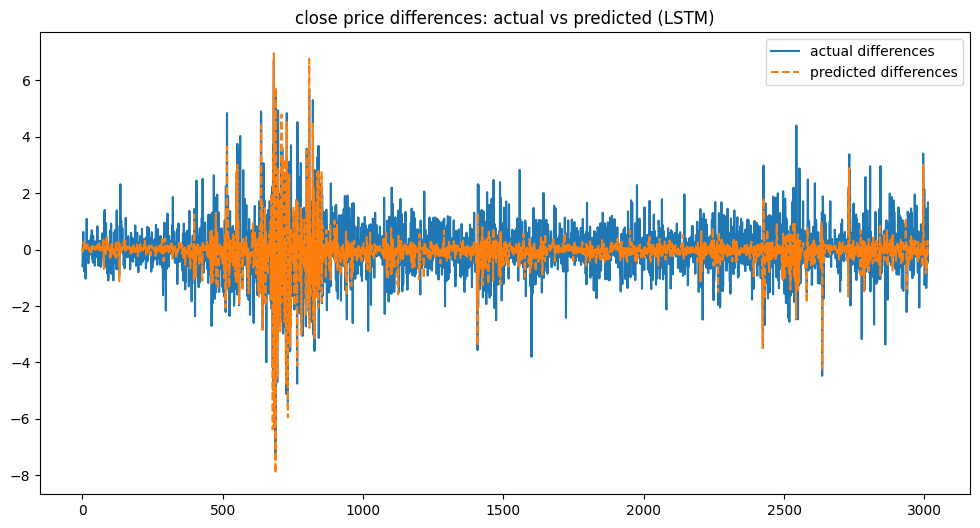

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(y_scaled_actual, label='actual differences')
plt.plot(y_scaled_pred, label='predicted differences', linestyle='dashed')
plt.title("close price differences: actual vs predicted (LSTM)")
plt.legend()
plt.show()

aarima and sarima

In [29]:
arima_order = (3, 1, 2)  # You can tune these parameters
arima_model = ARIMA(y, order=arima_order)
arima_fitted = arima_model.fit()

/home/ryu/code/minorproject/VENV/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ryu/code/minorproject/VENV/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [31]:
y_pred_arima = arima_fitted.predict(start=0, end=len(y) - 1)

In [32]:
sarima_order = (5, 1, 2)   # Non-seasonal parameters
seasonal_order = (1, 1, 1, 12)  # Seasonal parameters (tune `m`)
sarima_model = SARIMAX(y, order=sarima_order, seasonal_order=seasonal_order)
sarima_fitted = sarima_model.fit()

In [33]:
y_pred_sarima = sarima_fitted.predict(start=0, end=len(y) - 1)

In [34]:
mse_arima = mean_squared_error(y, y_pred_arima)
r2_arima = r2_score(y, y_pred_arima)

In [35]:
mse_sarima = mean_squared_error(y, y_pred_sarima)
r2_sarima = r2_score(y, y_pred_sarima)

In [36]:
print(f"ARIMA MSE: {mse_arima:.6f}, R²: {r2_arima:.6f}")
print(f"SARIMA MSE: {mse_sarima:.6f}, R²: {r2_sarima:.6f}")

ARIMA MSE: 0.990227, R²: 0.007998
SARIMA MSE: 1.002451, R²: -0.004248


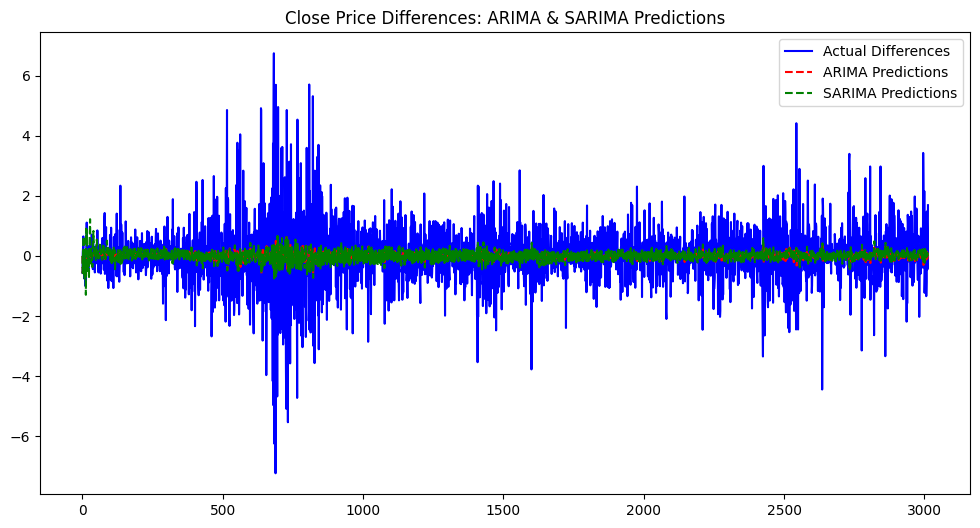

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual Differences', color='blue')
plt.plot(y_pred_arima, label='ARIMA Predictions', linestyle='dashed', color='red')
plt.plot(y_pred_sarima, label='SARIMA Predictions', linestyle='dashed', color='green')
plt.title("Close Price Differences: ARIMA & SARIMA Predictions")
plt.legend()
plt.show()